<h1> General Info</h1>

In [ ]:
#TO DO

"""
1- Implement a naive CNN on the imagenet data
2- Implement Capsules

Other info:
Stanford prepared the Tiny ImageNet dataset for their CS231n course. 
The dataset spans 200 image classes with 500 training examples per class. 
The dataset also has 50 validation and 50 test examples per class.

Tiny ImageNet Challenge is a similar challenge as ImageNet with a smaller dataset but
less image classes. It contains 200 image classes, a training 
dataset of 100, 000 images, a validation dataset of 10, 000
images, and a test dataset of 10, 000 images. All images are
of size 64×64.
"""

<h1> Import Training Dataset <h1>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import datetime
import os
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model

%load_ext tensorboard

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(directory= 'tiny-imagenet-200/train/', 
                                                    target_size=(64, 64), 
                                                    batch_size=256, 
                                                    class_mode='categorical', 
                                                    shuffle=True, 
                                                    seed=42,
                                                    subset ="training"
                                                   )

Found 100000 images belonging to 200 classes.


<h2> Examine Train Images </h2>

(256, 64, 64, 3)
(256, 200)


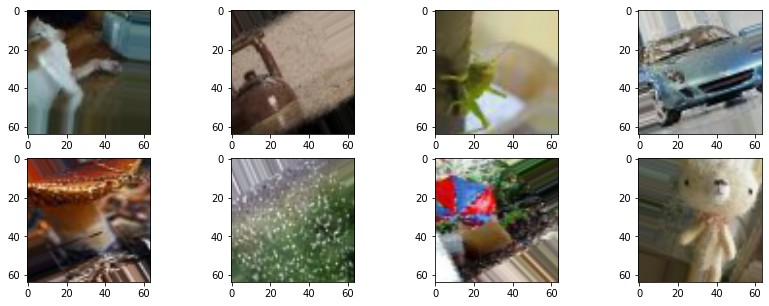

In [3]:
import numpy as np

x_batch, y_batch = next(train_generator)

print(x_batch.shape)
print(y_batch.shape)

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow((x_batch[i,:,:,:]), interpolation='bilinear')

<h2> Import Validation Dataset <h2>

In [4]:
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)

valid_datagen  = ImageDataGenerator(
    rescale=1./ 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_generator = valid_datagen.flow_from_dataframe(dataframe=val_data, 
                                                         directory='./tiny-imagenet-200/val/images/', 
                                                         x_col='File', 
                                                         y_col='Class', 
                                                         target_size=(64, 64),
                                                         color_mode='rgb', 
                                                         class_mode='categorical', 
                                                         batch_size=256, 
                                                         shuffle=True, 
                                                         seed=42,
                                                        subset ="training")

Found 10000 validated image filenames belonging to 200 classes.


<h2> Generic Callbacks </h2>

In [6]:
# Early stopping and tensorboard graphs

es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=30)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir)

<h2> Building and training the Model - Lighter version of VGG inspired Model </h2>

In [ ]:
model= Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(64,64,3),
                 kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(34, activation='softmax'))

model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=['accuracy'])

history = model.fit(train_generator, 
                    epochs=5000, 
                    validation_data=validation_generator, 
                    callbacks=[es]
                             )

score = model.evaluate(train_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, show_shapes=True)

<h2> Building and training the Model - Inception </h2>

In [ ]:
# Applies parallel convolutional layers with different sized filters (1x1, 3x3 and 5x5) followed by a 3x3 max pooling layer 
# and the results are then concatentated

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

input_img = Input(shape = (64, 64, 3))

# 1x1 conv
conv1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)

# 3x3 conv
conv3 = Conv2D(32, (3,3), padding='same', activation='relu')(input_img)

# 5x5 conv
conv5 = Conv2D(32, (5,5), padding='same', activation='relu')(input_img)

# 3x3 max pooling
pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)

# concatenate filters, assumes filters/channels last
layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)

output = Flatten()(layer_out)
out    = Dense(34, activation='softmax')(output)

model = Model(inputs = input_img, outputs = out)

model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=['accuracy'])

history = model.fit(train_generator, 
                    epochs=2000, 
                    validation_data=validation_generator, 
                    callbacks=[es]
                             )

score = model.evaluate(train_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, show_shapes=True)

<h2> Building and training the Model - Resnet50V2</h2>

In [ ]:
# Residual Network (ResNet) is a Convolutional Neural Network (CNN) architecture which was designed to enable hundreds or thousands of 
# convolutional layers. While previous CNN architectures had a drop off in the effectiveness of additional layers, 
# ResNet can add a large number of layers with strong performance.

In [ ]:
from tensorflow.keras.applications import ResNet50V2

model = ResNet50V2(
    include_top=True, weights=None, input_shape=(64,64,3), classes=200
)


model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=['accuracy'])

history = model.fit(train_generator, 
                    epochs=5000, 
                    validation_data=validation_generator, 
                    callbacks=[es]
                             )

score = model.evaluate(train_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Resnet achieves only 0.3647 %

model.summary()
plot_model(model, show_shapes=True)

<h2> Building and training the Model - Resnet150V2</h2>

In [7]:
from tensorflow.keras.applications import ResNet152V2


model_2 = ResNet152V2(
    include_top=True, weights=None, input_shape=(64,64,3), classes=200
)


model_2.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=['accuracy'])

history = model_2.fit(train_generator, 
                    epochs=5000, 
                    validation_data=validation_generator, 
                    callbacks=[es]
                             )

score = model_2.evaluate(train_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 391 steps, validate for 40 steps
Epoch 1/5000
391/391 [==============================] - 597s 2s/step - loss: 5.1182 - accuracy: 0.0232 - val_loss: 59.2111 - val_accuracy: 0.0130
Epoch 2/5000
391/391 [==============================] - 154s 394ms/step - loss: 4.6208 - accuracy: 0.0612 - val_loss: 4.6142 - val_accuracy: 0.0634
Epoch 3/5000
391/391 [==============================] - 146s 372ms/step - loss: 4.3055 - accuracy: 0.0988 - val_loss: 4.9246 - val_accuracy: 0.0524
Epoch 4/5000
391/391 [==============================] - 144s 368ms/step - loss: 4.0571 - accuracy: 0.1310 - val_loss: 12.2669 - val_accuracy: 0.1089
Epoch 5/5000
391/391 [==============================] - 143s 366ms/step - loss: 3.8201 - accuracy: 0.1669 - val_loss: 4.1021 - val_accuracy: 0.1331
Epoch 6/5000
391/391 [==============================] - 148s 379ms/step - loss: 3.6491 - accuracy: 0.1922 - val_loss: 4.4518 - val_accuracy: 0.1103
Epoch 7/5000
391/391

In [8]:
model_2.summary()
plot_model(model_2, show_shapes=True)

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

<h1> Archive </h1>

In [ ]:
# import glob
# import re
# import os
# import numpy as np
# from PIL import Image


# class TinyImageNetLoader(object):
#     """Loader for images from the the Tiny ImageNet set for images of a specific class."""
#     def __init__(self, mode, data_path, data_type='float32'):
#         # mode = 'train' or 'val';
#         # data_path: the relative path of tiniy-imagenet, '../tiny-imagenet-200',
#         self.data_path = data_path
#         self.data_type = data_type
#         with open(self.path('wnids.txt')) as f: # detail info of image
#             wnids = f.readlines()
#             assert len(wnids) == 200
#             wnids = [x.strip() for x in wnids]
#             self.wnids = wnids
#             self.mode = mode
#         images = {}
#         if mode == 'val': # load validation set
#             with open(self.path('val/val_annotations.txt')) as f:
#                 labels = f.readlines()
#                 #assert len(labels) == 10000
#                 labels = [x.split('\t')[:2] for x in labels]
#                 for image, wnid in labels:
#                     #assert wnid in self.wnids
#                     #assert image.endswith('.JPEG')
#                     images.setdefault(wnid, []).append(data_path + '/val/images/' + image)

#                 #assert len(images) == len(wnids)
#                 #for wnid in images:
#                 #    assert len(images[wnid]) == 50
#         if mode == 'train': # load training set
#             filenames = glob.glob(data_path + '/train/*/images/*.JPEG')
#             for filename in filenames:
#                 wnid = re.search(r'n\d+', filename)
#                 #label = str(label_dict[match.group()])
#                 #filenames_labels.append((filename, label))
#                 images.setdefault(wnid.group(), []).append(filename)
#         self.imagefiles_wnid_dict = images
#         # print(len(self.imagefiles_wnid_dict))
            

#     def path(self, *path):
#         return os.path.join(self.data_path, *path)

#     def load_image(self, filename):
#         path = os.path.join(filename)
#         image = Image.open(path)
#         image = np.asarray(image)
#         if image.shape != (64, 64, 3):
#             # e.g. grayscale
#             return None
#         assert image.dtype == np.uint8
#         image = image.astype(self.data_type)
#         assert image.shape == (64, 64, 3)
#         return image

#     def load_n_images_all_classes(self, nb):
#         # nb: number of samples per class, for validation data, max =50, for train, max=500
#         # return: X_data in [n, 64, 64, 3], Y_data in [n, 1]
#         X_data=np.ndarray([nb*200,64,64,3], dtype=self.data_type)
#         Y_data=np.zeros([nb*200,200], dtype=self.data_type)# one hot encoded
#         arr = np.arange(nb*200)
#         np.random.shuffle(arr) # shuffle images
        
#         for label in range(200):
#             wnid = self.wnids[label]
#             files = self.imagefiles_wnid_dict[wnid]
#             for i, filename in enumerate(files):
#                 if i==nb:
#                     break
#                 #print(i,filename)
#                 raw_image = self.load_image(filename)
#                 #raw_image = raw_image.astype(np.float32)
#                 #print(label*nb+i)
#                 X_data[arr[label*nb+i],:,:,:] = raw_image
#                 Y_data[arr[label*nb+i],label] = 1
#                 #print(label)
#         return X_data, Y_data

In [ ]:
# path="C:\\Users\\Maged Helmy\\Desktop\\Projects\\jupyterNotebooks_general\\4_imageNet\\tiny-imagenet-200\\"

# load_data=TinyImageNetLoader("val",data_path=path)
# x_data, y_data= load_data.load_n_images_all_classes(nb=50)

In [ ]:
# len(x_data)